# OpenAI Gym ~ tweaking reward funtion (MountainCarContinuous-v0)
- *Wheeler task definition ( task wrapper, State decoder settings, NeuralNetwork, ReplayBuffer, .. )*

### Import generics

In [1]:
import os, time

os.chdir("..")

import numpy as np
import toml, gym

import torch
from torch.multiprocessing import Queue, Process

### Prepare statistic helpers

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def print_stats(scores, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Rewards')
    plt.xlabel(title)
    plt.show()

### Load task configs ~ this should be adopted offline for particular task

In [3]:
CFG = toml.loads(open('cfg.toml').read())
GYM_CFG = toml.loads(open('gym.toml').read())

torch.set_default_tensor_type(CFG['tensor'])

CFG['task'] = "MountainCarContinuous-v0"

### Import wheeler environment and particular utils we want to use ~ general ones ( shared across tasks )

In [4]:
from utils.task import Task
from utils.taskinfo import *

from utils.rbf import *
from utils.normalizer import *

from utils.taskmgr import *
from utils.replay import *

from utils.fastmem import Memory

from utils.curiosity import *

from agent.zer0bot import agent_launch

### Define Task wrapper ~ when is goal met, how to step ( update rewards function, .. ), when / how to reset

In [5]:
class MCarTask(Task):
    def __init__(self, cfg, env, objective_id, bot_id, action_low, action_high, rewarder):
        self.reward = 0
        self.rewards = []

        super().__init__(
                cfg,
                env,
                objective_id,
                bot_id,
                action_low, action_high)

        self.rewarder = rewarder

    def reset(self, seed = None, test = False):
        state = super().reset(seed, test)
        self.rewards.append(self.reward)
        self.reward = 0
        self.prev_state = state[0]
        return state

    def step_ex(self, action, test = False):
        state, reward, done, _ = self.env.step(self.bot_id, self.objective_id, action)

        if test: return action, state.reshape(1, -1), reward, done, True

        self.reward += (done and reward > 0)

        curiosity_test = '''
        if not test and reward < 0:
            ss, ns = np.vstack([s] * self.cfg['history_count']), np.vstack([n] * self.cfg['history_count'])
            ss = ss.reshape(1, -1)
            ns = ns.reshape(1, -1)
            reward = self.rewarder.weight(ss, ns, action)[0]
            self.rewarder.update(ss, ns, action)
        self.prev_state = state

        reward_update  = '''
        if not test and not done:# and sum(self.rewards) < 3
            true_state = np.abs(np.cos(np.pi/3.) + state[0])
            reward += -(1. - true_state)
#        '''

        return action, state, reward, done, True

    def goal_met(self, states, rewards, n_steps):
        return sum(rewards) > 90.

### Generic proxy for creating our Task ( multiprocess environments purpose mainly ) 
- but can also add wrapping function approx values ( action value to tanh, sigmoid, .. ) - this not works well with PPO now

In [6]:
class MCarInfo(TaskInfo):
    def __init__(self, env, replaybuf, factory, Mgr, args):
        super().__init__(
                len(env.reset()), 1, -1, +1,
                CFG,
                replaybuf,
                factory, Mgr, args)

        self.rewarder = CuriosityPrio(
                self.state_size, self.action_size,
                self.action_range, self.wrap_action, "cpu", GYM_CFG)

    def new(self, cfg, bot_id, objective_id):
        return MCarTask(cfg,
                self.env,
                objective_id, bot_id,
                self.action_low, self.action_high,
                self.rewarder)

    @staticmethod
    def factory(ind): # bare metal task creation
        print("created %i-th task"%ind)
        CFG = toml.loads(open('cfg.toml').read())
        return gym.make(CFG['task'])
    
#    def wrap_action(self, x):
#        return torch.tanh(x)

### Implement callback for testing policy ~ per X training rounds, we want to test it ~ enable visuals if you want

In [7]:
def context_callback(count, print_every):
    context_callback.z = 0
    context_callback.scores = []
    context_callback.total_scores = []
    def callback(task, agent, scores):
        context_callback.z += 1
        context_callback.total_scores += scores
        if 0 == context_callback.z % print_every:
            print("\nTEST review : ", np.mean(context_callback.scores[-print_every:]))
        # we can save scores to main queue, and avarage them, or we can ..
        # run testing w/ visuals :
        for _ in range(count):
            done, states, rewards = task.test_policy(agent)
            rewards = sum(rewards)
            context_callback.scores.append(rewards)            
            if not done:
                return None

        print("\n")
        print("="*80)
        print("training over", context_callback.z * GYM_CFG['n_simulations'] * GYM_CFG['mcts_rounds'])
        print("="*80)
        
        print_stats(context_callback.scores, "all-out::testing phase")

        return context_callback.total_scores
    return callback

### Prepare neural network which we will be using

In [8]:
from models import ddpg_model, noisy_model, state_action_model

def CriticNN(state_size, action_size, wrap_value, cfg):
    return state_action_model.Critic(state_size, action_size, wrap_value, cfg, fcs1_units=256, fc2_units=128)

def ActorNN(state_size, action_size, wrap_action, cfg):
    return noisy_model.Actor(state_size, action_size, wrap_action, cfg, hiddens=[64, 32])
    return noisy_model.Actor(state_size, action_size, wrap_action, cfg, hiddens=[128, 64])
    return noisy_model.Actor(state_size, action_size, wrap_action, cfg, hiddens=[400, 300])

### Select encoders

In [9]:
from utils.encoders import *
from utils.rnn import *#GRUEncoder

def encoderstack(env):
    encoder = RBFEncoder(GYM_CFG, env, [5., 2., 1., .5], [5] * 4)
    return encoder

    norm = BatchNormalizer3D(GYM_CFG, encoder.out_size())
    encoder = StackedEncoder(GYM_CFG, len(env.reset()), encoder, norm)
    return encoder

    experience = FasterGRUEncoder(GYM_CFG, encoder.total_size())#GRU#LSTM
    encoder_norm = StackedEncoder(GYM_CFG, len(env.reset()), encoder, experience)
    print(encoder_norm)
    return encoder_norm

### Cook Task : replay buffer ( fast / prio-gae-rnn ) + task manager ( local / remote / unity )

In [10]:
def taskfactory(env):
    return MCarInfo(env, Memory, MCarInfo.factory, LocalTaskManager, ())
    return MCarInfo(env, ReplayBuffer, MCarInfo.factory, LocalTaskManager, ())
    return MCarInfo(env, ReplayBuffer, MCarInfo.factory, RemoteTaskManager, (LocalTaskManager, 1 + GYM_CFG['n_simulations']))

### Glue it all together ~ select buffer, encoders, agents, ... and RUN!!

{'tensor': 'torch.DoubleTensor', 'task': 'MountainCarContinuous-v0', 'total_simulations': 2, 'cross_exp_size': 5000, 'max_reward_val': 1000, 'min_reward_val': -1000}
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
created 0-th task
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
created 1-th task
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[0>   1::     0] training =  0, steps =  23, max_step = 10000, reward=-22.453170 ::[[0.02253347]]: 

/home/xyz/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


[0>   1::     0] training =  0, steps = 146, max_step = 10000, reward=-139.942317 ::[[0.53884198]]: 

[0>   5::     0] training =  0, steps = 999, max_step = 999, reward=-976.451203 ::[[-0.07428039]]:  TARGET:-4.355519 replay::3996 ]<-----
TEST review :  -5.983615870350453
[0>  10::     0] training =  0, steps = 999, max_step = 999, reward=-928.424856 ::[[0.15152562]]:  [ TARGET:-8.000849 replay::8991 ]<----
TEST review :  -4.489535203309337
[0>  15::     0] training =  0, steps = 999, max_step = 999, reward=-905.921370 ::[[-0.38096772]]: [ TARGET:-9.699252 replay::10000 ]<-----
TEST review :  -7.243809918321142
[0>  20::     0] training =  0, steps = 999, max_step = 999, reward=-908.926020 ::[[-0.43819206]]: [ TARGET:-12.914779 replay::10000 ]<----
TEST review :  -13.683358173238952
[0>  25::     0] training =  0, steps = 999, max_step = 999, reward=-585.413894 ::[[0.11109489]]:  [ TARGET:-10.960509 replay::10000 ]<----
TEST review :  -12.805697473523688
[0>  30::     0] training =  0, steps = 171, max_step = 171, reward=-20.794754 ::[[-0.46499681]]:  [ TARGET:-14.830892 replay::10000

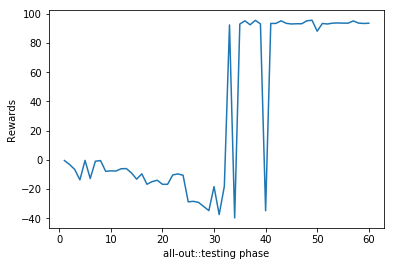

[0>  37::     0] training =  0, steps = 272, max_step = 165, reward=-74.018287 ::[[-0.24330709]]:   TARGET:-9.477889 replay::10000 ]<------

training over 37


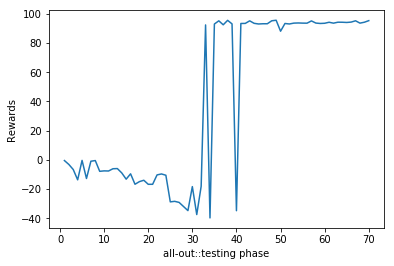

AGENT OVER
CRITIC OVER
SIMULATION OVER
FINISHED!


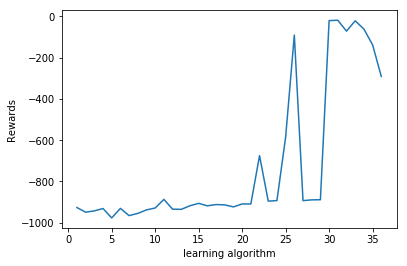

In [11]:
def main():
    print(CFG)

    env = gym.make(CFG['task'])
    
    encoder = encoderstack(env)
    task_factory = taskfactory(env)
    task = task_factory.new(GYM_CFG, 0, -1)
    
    callback = context_callback(10, 5)
    def callback_task(agent, stop_q):
        return callback(task, agent, stop_q)

    stop_q = Queue()
    agent_launch(0, GYM_CFG, task_factory, encoder, ActorNN, CriticNN, stop_q, callback_task)
    
    scores = stop_q.get()
    print("FINISHED!")
    print_stats(scores, "learning algorithm")

if '__main__' == __name__:
    main()